## Project Requirements
Predict the total score of an IPL match using a deep learning model, performing necessary data preprocessing, feature engineering, time-series splitting, model definition, training, evaluation, and visualization of results on the `ipl` DataFrame.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf

In [2]:
ipl = pd.read_csv('/content/drive/MyDrive/LinkedInProjects/AI/Dataset/ipl_data.csv')
ipl.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


## Exploratory Data Analysis

/tmp/ipython-input-1600510140.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=matches_count.values, y=matches_count.index, palette="rainbow")


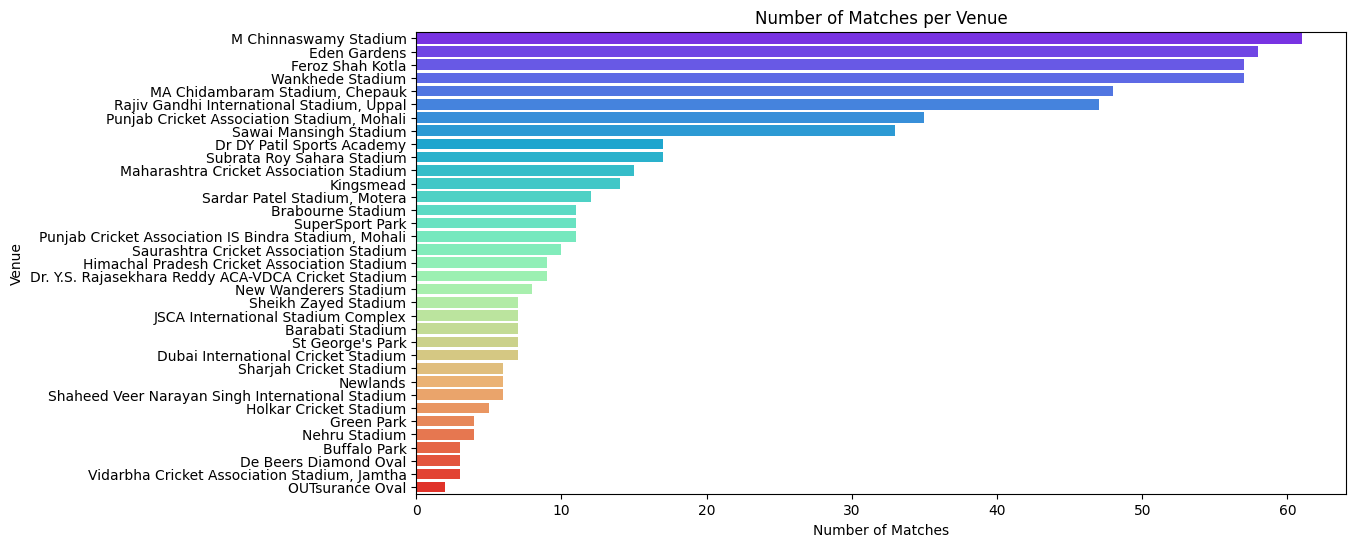

In [3]:
data = ipl.copy()
matches_per_venue = data[['mid', 'venue']].drop_duplicates()
matches_count = matches_per_venue['venue'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=matches_count.values, y=matches_count.index, palette="rainbow")
plt.title('Number of Matches per Venue')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.show()

/tmp/ipython-input-1761167641.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=runs_by_batsman.values, y=runs_by_batsman.index,palette="pastel")


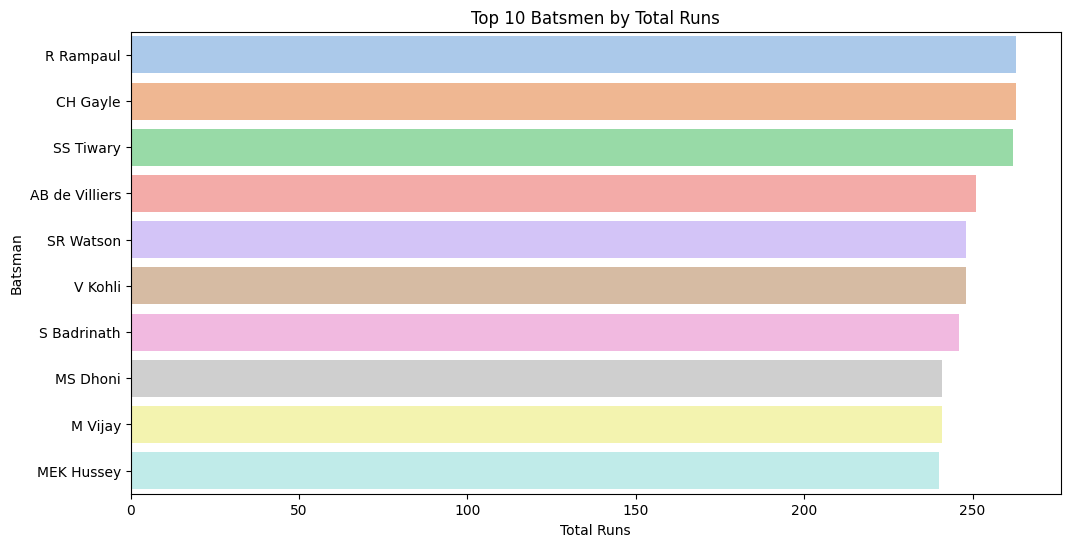

In [4]:
runs_by_batsman = data.groupby('batsman')['runs'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=runs_by_batsman.values, y=runs_by_batsman.index,palette="pastel")
plt.title('Top 10 Batsmen by Total Runs')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.show()

/tmp/ipython-input-525811339.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wickets_by_bowler.values,


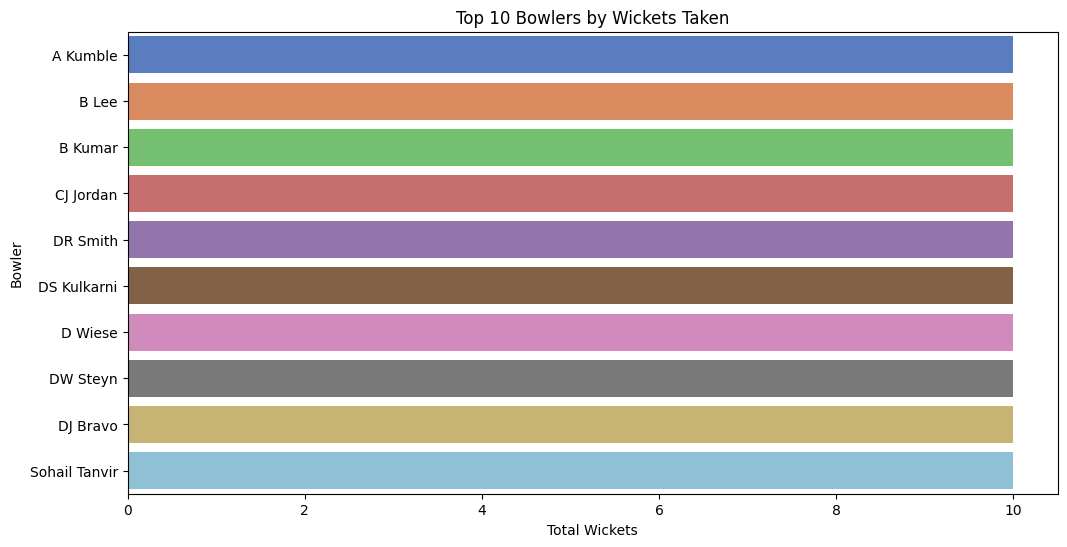

In [5]:
wickets_by_bowler = data.groupby(
    'bowler')['wickets'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=wickets_by_bowler.values,
            y=wickets_by_bowler.index, palette="muted")
plt.title('Top 10 Bowlers by Wickets Taken')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.show()

## Data Preprocessing and Feature Selection

Prepare the `ipl` DataFrame for deep learning by selecting relevant features, handling categorical variables through one-hot encoding, and converting the 'date' column into a usable format if necessary.

In [6]:
data = ipl.copy()

# Dropping irrelevant columns for prediction
data.drop(labels=['mid', 'date', 'striker', 'non-striker'], axis=1, inplace=True)

# One-hot encoding for categorical features
data = pd.get_dummies(data, columns=['bat_team', 'bowl_team', 'venue'])

# Display the first few rows of the preprocessed DataFrame
data.head()

,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Deccan Chargers,...,venue_Saurashtra Cricket Association Stadium,venue_Sawai Mansingh Stadium,venue_Shaheed Veer Narayan Singh International Stadium,venue_Sharjah Cricket Stadium,venue_Sheikh Zayed Stadium,venue_St George's Park,venue_Subrata Roy Sahara Stadium,venue_SuperSport Park,"venue_Vidarbha Cricket Association Stadium, Jamtha",venue_Wankhede Stadium
0,SC Ganguly,P Kumar,1,0,0.1,1,0,222,False,False,...,False,False,False,False,False,False,False,False,False,False
1,BB McCullum,P Kumar,1,0,0.2,1,0,222,False,False,...,False,False,False,False,False,False,False,False,False,False
2,BB McCullum,P Kumar,2,0,0.2,2,0,222,False,False,...,False,False,False,False,False,False,False,False,False,False
3,BB McCullum,P Kumar,2,0,0.3,2,0,222,False,False,...,False,False,False,False,False,False,False,False,False,False
4,BB McCullum,P Kumar,2,0,0.4,2,0,222,False,False,...,False,False,False,False,False,False,False,False,False,False


## Feature Engineering and Scaling

Create additional features that could enhance prediction accuracy, such as run rate.

In [7]:
data['current_run_rate'] = np.where(data['overs'] != 0, data['runs'] / data['overs'], 0)

# Identify numerical features to scale (excluding one-hot encoded and 'total')
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('total') # Exclude the target variable
# The one-hot encoded columns are Boolean, which are not included in np.number type for numerical_cols, so no explicit exclusion is needed for them.

# Initialize and apply StandardScaler
scaler = preprocessing.StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Display the first few rows of the DataFrame with new and scaled features
data.head()

,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Deccan Chargers,...,venue_Sawai Mansingh Stadium,venue_Shaheed Veer Narayan Singh International Stadium,venue_Sharjah Cricket Stadium,venue_Sheikh Zayed Stadium,venue_St George's Park,venue_Subrata Roy Sahara Stadium,venue_SuperSport Park,"venue_Vidarbha Cricket Association Stadium, Jamtha",venue_Wankhede Stadium,current_run_rate
0,SC Ganguly,P Kumar,-1.513413,-1.198815,-1.677434,-2.160136,-1.06358,222,False,False,...,False,False,False,False,False,False,False,False,False,0.823111
1,BB McCullum,P Kumar,-1.513413,-1.198815,-1.660110,-2.160136,-1.06358,222,False,False,...,False,False,False,False,False,False,False,False,False,-0.916045
2,BB McCullum,P Kumar,-1.492930,-1.198815,-1.660110,-2.093085,-1.06358,222,False,False,...,False,False,False,False,False,False,False,False,False,0.823111
3,BB McCullum,P Kumar,-1.492930,-1.198815,-1.642787,-2.093085,-1.06358,222,False,False,...,False,False,False,False,False,False,False,False,False,-0.336327
4,BB McCullum,P Kumar,-1.492930,-1.198815,-1.625464,-2.093085,-1.06358,222,False,False,...,False,False,False,False,False,False,False,False,False,-0.916045


## Data Splitting for Time Series

Split the preprocessed data into training and testing sets, ensuring a time-series split where earlier matches form the training set and later matches form the testing set.


To prepare the data for modeling, I need to separate the features (X) from the target variable (y), which is 'total'.



In [8]:
X = data.drop(columns=['total', 'batsman', 'bowler'])
y = data['total']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (76014, 69)
Target shape: (76014,)


To ensure a time-series split, I will calculate the index for an 80/20 train-test split, then use this index to divide the features (X) and the target (y) into training and testing sets.



In [9]:
split_index = int(len(data) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60811, 69)
X_test shape: (15203, 69)
y_train shape: (60811,)
y_test shape: (15203,)


## Deep Learning Model Definition

Define the architecture of a deep learning model using Keras/TensorFlow.

To define the deep learning model architecture, I will use Keras to create a Sequential model, adding the specified Dense layers with appropriate neuron counts and activation functions for the input, hidden, and output layers.



In [10]:
from keras.models import Sequential
from keras.layers import Dense

# Initialize the Sequential model
model = Sequential()

# Add the first Dense layer with 100 neurons and 'relu' activation
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

# Add a second Dense layer with 50 neurons and 'relu' activation
model.add(Dense(50, activation='relu'))

# Add the output Dense layer with 1 neuron (for regression) and no activation
model.add(Dense(1))

# Display the model summary to confirm the architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)

To define the deep learning model architecture, I will use Keras to create a Sequential model, addressing the UserWarning by explicitly defining the input layer using `tf.keras.Input` as recommended, then adding the specified Dense layers with appropriate neuron counts and activation functions for the input, hidden, and output layers.



In [11]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Initialize the Sequential model
model = Sequential()

# Add the input layer using Input()
model.add(Input(shape=(X_train.shape[1],)))

# Add the first Dense layer with 100 neurons and 'relu' activation
model.add(Dense(100, activation='relu'))

# Add a second Dense layer with 50 neurons and 'relu' activation
model.add(Dense(50, activation='relu'))

# Add the output Dense layer with 1 neuron (for regression) and no activation
model.add(Dense(1))

# Display the model summary to confirm the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 100)            │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,101 (47.27 KB)

 Trainable params: 12,101 (47.27 KB)

 Non-trainable params: 0 (0.00 B)

With the model architecture defined, the next crucial step is to compile it. This involves specifying the optimizer, loss function, and metrics, which are essential for the model to be trained effectively.



In [12]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
print("Model compiled successfully with Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric.")

Model compiled successfully with Adam optimizer, Mean Squared Error loss, and Mean Absolute Error metric.


## Deep Learning Model Training

Train the defined deep learning model using the training data (`X_train` and `y_train`). This will involve fitting the model for a specified number of epochs with a batch size, and storing the training history for later evaluation.

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
print("Model training completed and history stored.")

Epoch 1/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 9514.7949 - mean_absolute_error: 72.5988 - val_loss: 629.3550 - val_mean_absolute_error: 19.3480
Epoch 2/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 390.8453 - mean_absolute_error: 14.8193 - val_loss: 581.5066 - val_mean_absolute_error: 18.3622
Epoch 3/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 363.3670 - mean_absolute_error: 14.1700 - val_loss: 580.7165 - val_mean_absolute_error: 18.1300
Epoch 4/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 334.8545 - mean_absolute_error: 13.5882 - val_loss: 585.6589 - val_mean_absolute_error: 18.2091
Epoch 5/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 323.3571 - mean_absolute_error: 13.2707 - val_loss: 626.6133 - val_mean_absolute_error: 18.9354
Epoch 6/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 285.9156 - mean_absolute_error: 12.3633 - val_loss: 649.3823 - val_mean_absolute_error: 19.3574
Epoch 7/50
761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 250

## Model Evaluation and Prediction

Evaluate the trained deep learning model's performance on the test set (`X_test`, `y_test`) using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [14]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(loss)

print(f"Mean Squared Error (MSE) on test set: {loss:.2f}")
print(f"Mean Absolute Error (MAE) on test set: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse:.2f}")

# Make predictions on the test set
y_pred = model.predict(X_test)

print("Predictions made on the test set. y_pred contains the predicted scores.")

Mean Squared Error (MSE) on test set: 2310.06
Mean Absolute Error (MAE) on test set: 38.14
Root Mean Squared Error (RMSE) on test set: 48.06
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predictions made on the test set. y_pred contains the predicted scores.


## Visualize Predictions

Plot the actual versus predicted scores from the test set to visually assess the model's performance and identify any patterns in its errors.


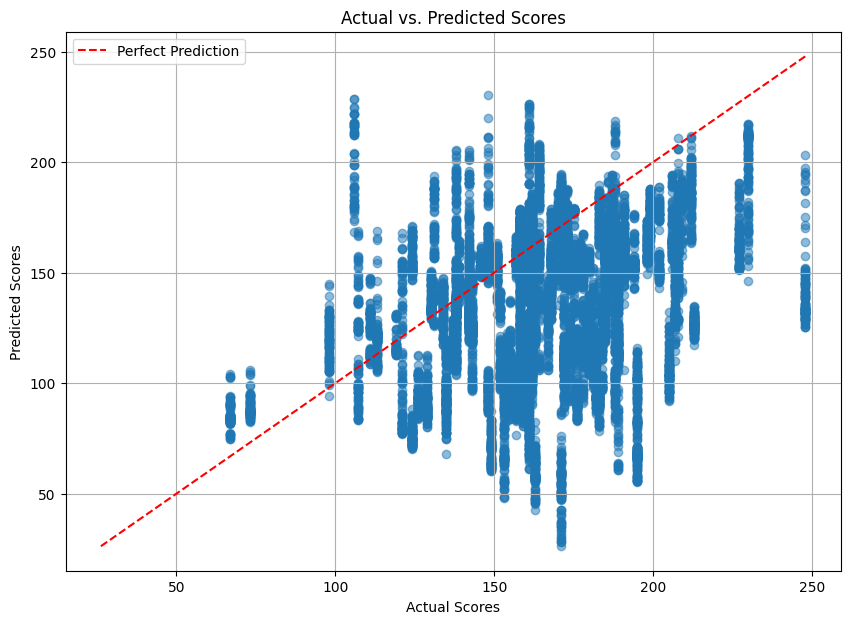

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs. Predicted Scores')
plt.legend()
plt.grid(True)
plt.show()

### Data Analysis Key Findings
*   The deep learning model achieved a Mean Absolute Error (MAE) of \$38.14\$ on the test set.
*   The Root Mean Squared Error (RMSE) for the model on the test set was calculated to be \$48.06\$.
*   The Mean Squared Error (MSE) on the test set, which was the loss returned by the evaluation, was \$2310.06\$.
*   A scatter plot visualizing actual versus predicted scores was generated, including a diagonal line representing perfect predictions, to allow for a visual assessment of the model's accuracy and identification of prediction patterns.